In [198]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [199]:
# read data into a DataFrame
data = pd.read_csv("../../data/cleaned_reviews.tsv", sep="\t")

#make a copy of columns I need from raw data
df1 = data
df1.head()

,rating,vote,verified,reviewTime,reviewerName,reviewText,summary
0,5,0,True,"07 14, 2014",Alvey,great read every issue,Five Stars
1,3,0,True,"06 24, 2014",Jeff A Milne,magazine great time technology magazine new st...,Great While it lasted
2,5,0,True,"06 1, 2014",P. R THOMPSON,ive read maximum pc mpc many year article tech...,For Both the Newbie and The Advanced PC User
3,5,0,True,"05 15, 2014",Earle Williams,order magazine grandson then 7 go 30 wasis dep...,Great Gift
4,4,0,True,"03 28, 2014",JJM,subscribed nook version year thoroughly enjoy ...,Decent magazine at a good price


In [200]:
df1["helpful"] = np.where(data.vote >= 0.01, 1, 0)

df1.head(100)

,rating,vote,verified,reviewTime,reviewerName,reviewText,summary,helpful
0,5,0,True,"07 14, 2014",Alvey,great read every issue,Five Stars,0
1,3,0,True,"06 24, 2014",Jeff A Milne,magazine great time technology magazine new st...,Great While it lasted,0
2,5,0,True,"06 1, 2014",P. R THOMPSON,ive read maximum pc mpc many year article tech...,For Both the Newbie and The Advanced PC User,0
3,5,0,True,"05 15, 2014",Earle Williams,order magazine grandson then 7 go 30 wasis dep...,Great Gift,0
4,4,0,True,"03 28, 2014",JJM,subscribed nook version year thoroughly enjoy ...,Decent magazine at a good price,0
...,...,...,...,...,...,...,...,...
95,1,0,True,"01 5, 2015",Calman86,suck period,One Star,0
96,5,0,True,"11 2, 2014",Aneudi Diaz,love insightful knowledge article whether late...,I love the insightful knowledge of articles,0
97,5,0,True,"10 29, 2014",Daniel R. Dause,excellent value clothes little young like article,Five Stars,0
98,2,0,True,"09 21, 2014",carlos rodriguez,many ad whole magazine ad cant believe real me...,I cant believe real men dress like that. I jus...,0


In [201]:
#make a copy
df2 = df1.copy(deep = True)

In [202]:
#tokenize text with Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.1, max_df=0.9,
                             ngram_range=(1, 4), 
                             stop_words='english')
vectorizer.fit(df2['reviewText'].values.astype("U"))

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 4),
                stop_words='english')

In [203]:
X_train = vectorizer.transform(df2['reviewText'].values.astype("U"))
vocab = vectorizer.get_feature_names()

/Users/frederikvincentprimdahl/Library/Caches/pypoetry/virtualenvs/amazon-sentiment-eV3x1PQ_-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [204]:
#find best logistic regression parameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
feature_set = X_train
gs = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)], 'class_weight': [None, 'balanced']},
    scoring='roc_auc'
)

gs.fit(X_train, df2.helpful)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [100000, 10000, 1000, 100, 10, 1, 0.1, 0.01,
                               0.001, 0.0001],
                         'class_weight': [None, 'balanced']},
             scoring='roc_auc')

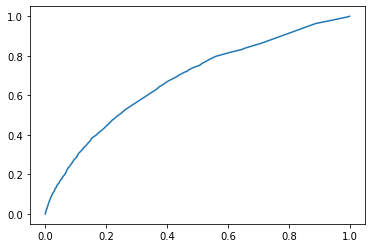

In [205]:
#plot ROC/AUC curve
from sklearn.metrics import roc_auc_score, roc_curve
actuals = gs.predict(feature_set) 
probas = gs.predict_proba(feature_set)
plt.plot(roc_curve(df2[['helpful']], probas[:,1])[0], roc_curve(df2[['helpful']], probas[:,1])[1])

In [206]:
# ROC/AUC score
y_score = probas
test2 = np.array(list(df2.helpful))
y_true = test2
roc_auc_score(y_true, y_score[:,1].T)

0.680026554967185

In [207]:
#Apply TfidfVectorizer to review text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import metrics

model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1,random_state=5)

vectorizer = TfidfVectorizer(min_df = 0.05, max_df=0.95,
                             ngram_range=(1, 2), 
                             stop_words='english')
vectorizer.fit(df1['reviewText'].values.astype("U"))

TfidfVectorizer(max_df=0.95, min_df=0.05, ngram_range=(1, 2),
                stop_words='english')

In [208]:
X_train = vectorizer.transform(df1['reviewText'].values.astype("U"))
vocab = vectorizer.get_feature_names()
sse_err = []
res = model.fit(X_train)
vocab = np.array(vocab)
cluster_centers = np.array(res.cluster_centers_)
sorted_vals = [res.cluster_centers_[i].argsort() for i in range(0,np.shape(res.cluster_centers_)[0])]
words=set()
for i in range(len(res.cluster_centers_)):
    words = words.union(set(vocab[sorted_vals[i][-10:]]))
words=list(words)

print(words)

['magazine', 'receive', 'gift', 'time', 'year', 'month', 'order', 'read', 'issue', 'enjoy', 'great', 'good', 'love', 'article', 'really', 'like', 'subscription']


/Users/frederikvincentprimdahl/Library/Caches/pypoetry/virtualenvs/amazon-sentiment-eV3x1PQ_-py3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [209]:
#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]

In [210]:
# how many observations are in each cluster
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,rating,vote,verified,reviewTime,reviewerName,reviewText,summary,helpful
cluster,,,,,,,,
0,2915,2915,2915,2915,2915,2915,2915,2915
1,3048,3048,3048,3048,3048,3048,3046,3048
2,40037,40037,40037,40037,40034,39968,40031,40037
3,12636,12636,12636,12636,12635,12636,12633,12636


In [211]:
# what does each cluster look like
df1.groupby('cluster').mean()

,rating,vote,verified,helpful
cluster,,,,
0,3.177015,3.007890,1.0,0.347513
1,4.127625,2.072178,1.0,0.265092
2,4.334316,0.991783,1.0,0.149537
3,4.074549,1.829851,1.0,0.248417


In [212]:
# correlation matrix
df1.corr()


,rating,vote,verified,helpful,cluster
rating,1.000000,-0.125217,NaN,-0.258395,0.088558
vote,-0.125217,1.000000,NaN,0.298758,-0.015466
verified,NaN,NaN,NaN,NaN,NaN
helpful,-0.258395,0.298758,NaN,1.000000,-0.025531
cluster,0.088558,-0.015466,NaN,-0.025531,1.000000


In [213]:
#add top words to train set
train_set=X_train[:,[np.argwhere(vocab==i)[0][0] for i in words]]


In [214]:
# how many observations are in each cluster
df1['cluster'] = model.labels_
df1.groupby('cluster').count()

,rating,vote,verified,reviewTime,reviewerName,reviewText,summary,helpful
cluster,,,,,,,,
0,2915,2915,2915,2915,2915,2915,2915,2915
1,3048,3048,3048,3048,3048,3048,3046,3048
2,40037,40037,40037,40037,40034,39968,40031,40037
3,12636,12636,12636,12636,12635,12636,12633,12636


In [215]:
# what does each cluster look like
df1.groupby('cluster').mean()

,rating,vote,verified,helpful
cluster,,,,
0,3.177015,3.007890,1.0,0.347513
1,4.127625,2.072178,1.0,0.265092
2,4.334316,0.991783,1.0,0.149537
3,4.074549,1.829851,1.0,0.248417


In [216]:
# correlation matrix
df1.corr()

,rating,vote,verified,helpful,cluster
rating,1.000000,-0.125217,NaN,-0.258395,0.088558
vote,-0.125217,1.000000,NaN,0.298758,-0.015466
verified,NaN,NaN,NaN,NaN,NaN
helpful,-0.258395,0.298758,NaN,1.000000,-0.025531
cluster,0.088558,-0.015466,NaN,-0.025531,1.000000
